### This notebook serves the purpose of explaining the process of loading, cleaning, and getting the data ready before visualizing or/and training it.

The data is separated by a semicolon `;`, read them.

In [6]:
!pip install suntime

In [18]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna
from suntime import Sun


In [19]:
generation_data = pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=';', decimal=',')
temperature_data = pd.read_csv('/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=';', decimal=',')

You probably noticed the unbalanced row count but it does not matter as we will eliminate the empty rows later for another reason.

In [56]:
df_train = pd.concat([generation_data, temperature_data.drop('DateTime', axis=1)], axis=1)

In [57]:
df_train.drop(df_train.index[25560:], axis=0, inplace=True)

As we see, our `WWCode` has *6254* nan value, from the data explanation provided we know that this column represents the Weather code in the time range.

In [68]:
def preprocess(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df = df.set_index('DateTime')
    df['WWCode'] = df['WWCode'].fillna(0).astype(int)
    return df

In [69]:
# get test data from the desired date index (25560 index is where the date-time is 01-12-2021)
df_test = temperature_data.iloc[25560:26304] 
df_train = preprocess(df_train)
df_test = preprocess(df_test)

In [70]:
set(df_test["WWCode"]) - set(df_train["WWCode"])

from the [jodc-weather code source](https://www.jodc.go.jp/data_format/weather-code.html)

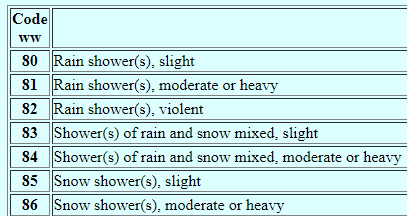

we can see each code and what it represents.

We change the category 84 samples to 83 because it is the nearest category to 84.

In [71]:
df_test['WWCode'] = df_test['WWCode'].replace([84], 83)

In [77]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    df_copy['hour'] = df_copy['date'].dt.hour
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['dayofmonth'] = df_copy['date'].dt.day
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear

    X = df_copy[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    
    if label:
        y = df_copy[label]
        X = pd.concat([df.drop(label, axis=1), X], axis=1)
        return X, y
    else:
        X = pd.concat([df, X], axis=1)
        return X

In [73]:
def split_train(df, split_date):
    train = df.loc[df.index <= split_date].copy()
    val = df.loc[df.index > split_date].copy()
    return train, val

In [74]:
split_date = '2021-05-01'
df_train, df_val = split_train(df_train, split_date)

In [78]:
x_train, y_train = create_features(df_train, label='Generation')
x_val, y_val = create_features(df_val, label='Generation')
x_test = create_features(df_test)

In [79]:
x_train

datasets = {'x_train': x_train,
            'y_train': y_train,
            'x_val': x_val,
            'y_val': y_val,
            'x_test': x_test
            }Save the data in its clean shape to use later easily 

In [80]:
hour_dic = {9:'day',10:'day',11:'day',12:'day',13:'day',14:'day',15:'day',16:'day',6:'mid',7:'mid',8:'mid',17:'mid',18:'mid',19:'mid',20:'mid',21:'mid',22:'night',23:'night',0:'night',1:'night',2:'night',3:'night',4:'night',5:'night'}
seasons = ['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']

season_dic = dict(zip(range(1,13), seasons))

In [81]:
x_train['part_day'] = x_train.hour.map(hour_dic)

x_val['part_day'] = x_val.hour.map(hour_dic)

x_test['part_day'] = x_test.hour.map(hour_dic)


In [82]:
dummy1 = pd.get_dummies(x_train['part_day'],drop_first=True)
x_train = pd.concat([x_train, dummy1], axis=1).drop(['part_day'], axis=1)

dummy1 = pd.get_dummies(x_val['part_day'],drop_first=True)
x_val = pd.concat([x_val, dummy1], axis=1).drop(['part_day'], axis=1)

dummy1 = pd.get_dummies(x_test['part_day'],drop_first=True)
x_test = pd.concat([x_test, dummy1], axis=1).drop(['part_day'], axis=1)

In [83]:
datasets = {'x_train': x_train,
            'y_train': y_train,
            'x_val': x_val,
            'y_val': y_val,
            'x_test': x_test
            }

In [86]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)
    early_stopping_rounds = trial.suggest_int("early_stopping_rounds", 100, 500)
    n_estimators = trial.suggest_int("n_estimators", 0, 10000)
    
    model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(
        datasets['x_train'],
        datasets['y_train'],
        early_stopping_rounds=early_stopping_rounds,
        eval_set=[(datasets['x_val'], datasets['y_val'])],
        verbose=1000,
    )
    preds_valid = model.predict(datasets['x_val'])
    rmse = mean_squared_error(datasets['y_val'], preds_valid, squared=False)

    return rmse

In [87]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

In [88]:
optuna_params = study.best_params

In [89]:
y_train[x_train['night'] == 1].mean()

In [91]:
model = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    **optuna_params
)
model.fit(
    datasets['x_train'],
    datasets['y_train'],
    early_stopping_rounds=optuna_params['early_stopping_rounds'],
    eval_set=[(datasets['x_val'], datasets['y_val'])],
    verbose=1000,
)

In [92]:
a = model.predict(x_test)

In [95]:
a[a < 0] = 0

In [102]:
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor

model2 = MultiOutputRegressor(AdaBoostRegressor(n_estimators=500))

In [103]:
test_multi = pd.DataFrame({"Close":y_train,'Max':y_train})

In [104]:
model2.fit(x_train,test_multi)


In [105]:
multi_out = model2.predict(x_val)

In [106]:
outt = []
for i in multi_out:
    outt.append(i[0])

In [107]:
mean_squared_error(y_val, outt, squared=False)

In [108]:
def create_sequence(dataset, length):
    data_sequences = []
    for index in range(len(dataset) - length):
        data_sequences.append(dataset[index: index + length])
    return np.asarray(data_sequences)

In [109]:
lstm = create_sequence(x_train,48)
lstm_val = create_sequence(x_val,48)

In [110]:
lstm.shape[2]

In [111]:
lstm_y = y_train[-lstm.shape[0]:]
lstm_val_y  = y_val[-lstm_val.shape[0]:]

In [112]:
lstm_y

In [113]:
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
# Configure the neural network model


model = Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(lstm.shape[1], lstm.shape[-1])))
model.add(Dropout(0.5))
model.add(LSTM(20,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

In [114]:
x_train.shape[1]

In [ ]:
history = model.fit(lstm, lstm_y, batch_size=128, epochs=150)


In [ ]:
predictions = model.predict(lstm_val)
len(predictions)

In [ ]:
mean_squared_error(lstm_val_y, predictions, squared=False)